# Applied Machine Learning - Homework 1

By Atmika Pai (aap253)

## Part 1 - Housing Prices
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<font color='green'> **Question 1: Join the House Prices - Advanced Regression Techniques competition on Kaggle. Download the
training and test data.**

In [22]:
test = pd.read_csv('housingprices_test.csv')
train = pd.read_csv('housingprices_train.csv')

data_dictionary = open("data_description.txt", "r")
#print(data_dictionary.read())

<font color='green'> **Question 2: Give 3 examples of continuous and categorical features in the dataset; choose one feature of each
type and plot the histogram to illustrate the distribution.**

3 examples of continuous features (data that is represented by numbers and have a range of values):
- Lot size in square feet (LotArea)
- Above grade (ground) living area square feet (GrLivArea)
- Value of miscellaneous feature (MiscVal)

3 examples of categorical features (data that can take on limited values, and the number of possible values are represented by a fixed set): 
- Zoning classification (MSZoning)
- Building Type (BldgType)
- Type of Roof (RoofStyle)

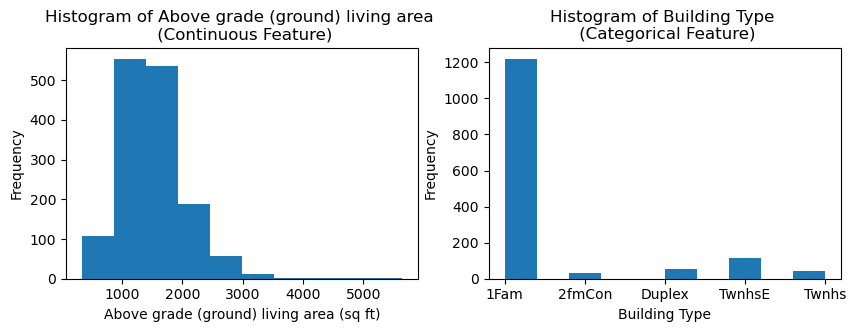

In [23]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(train.GrLivArea);
plt.title('Histogram of Above grade (ground) living area \n (Continuous Feature)');
plt.xlabel('Above grade (ground) living area (sq ft)');
plt.ylabel('Frequency');

plt.subplot(1, 2, 2)
plt.hist(train.BldgType);
plt.title('Histogram of Building Type \n (Categorical Feature)');
plt.xlabel('Building Type');
plt.ylabel('Frequency');

<font color='green'> **Question 3: Pre-process your data, explain your pre-processing steps, and the reasons why you need them.
(Hint: data pre-processing steps can include but are not restricted to: dealing with missing values,
normalizing numerical values, dealing with categorical values etc.)**

The train dataset has 81 columns. Some variables may not have strong predictive power in our regression. High dimensional data also requires more computational power, resulting in inefficiencies. Therefore, we must preprocess the data.

**Step 1) Removing columns with more than 50% blank values**

I chose to remove columns with more than 50% missing values. Although I could impute the mean or median of the observed data for the missing values, this approach is unreliable because more than 50% of the observations are blank. Imputing such a large portion of the data could introduce biases.

In [24]:
nan_values = pd.DataFrame(train.isnull().sum(axis = 0)).sort_values(by=0, ascending=False)
nan_values['NanValuePercent'] = nan_values[0]/len(train)
print(nan_values[nan_values.NanValuePercent >= 0.4])
train_preprocessed = train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType'], axis=1)

print("# features in dataset excluding features with more than 50% blank: ", len(train_preprocessed.columns)-1)

                0  NanValuePercent
PoolQC       1453         0.995205
MiscFeature  1406         0.963014
Alley        1369         0.937671
Fence        1179         0.807534
MasVnrType    872         0.597260
FireplaceQu   690         0.472603
# features in dataset excluding features with more than 50% blank:  75


**Step 2a) Eliminating numerical features with correlation below 50% with target variable (SalesPrice)**

Including features with low correlation can add noise, reducing model performance. A simpler model is also less prone to overfitting since it avoids learning irrelevant patterns. Hence, I am keeping only strongly correlated features in the hopes that the model will focus on the most important variables, contributing to better generalization, prediction, and interpretability.

I use the Corr() Pandas function Python to calculate the correlation matrix of a feature with the target variable. Features that have correlation below 0.5 are dropped from the train set. 

In [25]:
import pandas as pd

num_cols = train_preprocessed.select_dtypes(include=['int', 'float']).columns
train_preprocessed_num_cols = train_preprocessed[num_cols]

correlation = train_preprocessed_num_cols.corr()
correlation_with_target = correlation['SalePrice'].sort_values(ascending=False).drop(['SalePrice'])

print("# features in dataset: ", len(train_preprocessed.columns)-1)

print("# numerical features with weak correlation with target variable : ", 
      len(correlation_with_target.loc[correlation_with_target <= 0.5]));

dropped_num_cols = correlation_with_target.loc[correlation_with_target <= 0.5].index.to_list()
train_preprocessed = train_preprocessed.drop(dropped_num_cols, axis=1)

print("# total features in new preprocessed dataset: ", 
      len(train_preprocessed.columns)-1);

# features in dataset:  75
# numerical features with weak correlation with target variable :  27
# total features in new preprocessed dataset:  48


**Step 2b) Eliminating categorical features with F-statistic below 400**

The Analysis of Variance (Anova) F-statistic is a measure of between-group variance/ within-group variance, where the former measures how much the group means differ from the overall mean and the latter measures the variance within each group around its own mean. I used the metric often in my econometrics classes. In the context of regression with categorical features, it helps to assess whether the categorical variable has a significant effect on the dependent variable.

A higher F-statistic generally indicates that the categorical feature has more predictive power for the regression model, however, there is no established range, number, or threshold. 

In the context of housing prices, I observed that three features—**ExterQual**, **KitchenQual**, and **BsmtQual**—had the highest F-stats, all exceeding 400. The next highest F-stat was 269 for **GarageFinish**, while still significant, is noticeably lower than the other three features. Given this, I decided to set a threshold of 400 for feature selection, focusing on the most impactful predictors to improve both model interpretability and performance. 

**ChatGPT:** I used ChatGPT to formulate the anova_f_stat function in python.

In [26]:
cat_cols = train_preprocessed.select_dtypes(include=['object']).columns

def anova_f_stat(df, cat_feature, target):
    overall_mean = df[target].mean()
    groups = df.groupby(cat_feature)[target].agg(['mean', 'size'])
    ss_between = ((groups['mean'] - overall_mean)**2 * groups['size']).sum()
    ss_within = ((df[target] - df[cat_feature].map(groups['mean']))**2).sum()
    df_between = len(groups) - 1
    df_within = len(df) - len(groups)
    f_stat = (ss_between / df_between) / (ss_within / df_within)
    return f_stat

f_stats = pd.Series(dtype=float)
for feature in cat_cols:
    f_stats[feature] = anova_f_stat(train_preprocessed, feature, 'SalePrice')
f_stats = f_stats.sort_values(ascending=False)

print("# features in dataset: ", len(train_preprocessed.columns)-1)

print("# categorical features with weak correlation with target variable : ", 
      len(f_stats.loc[f_stats <= 400]));

dropped_cat_cols = f_stats.loc[f_stats <= 400].index.to_list()
train_preprocessed = train_preprocessed.drop(dropped_cat_cols, axis=1)

print("# total features in new preprocessed dataset: ", 
      len(train_preprocessed.columns)-1);

# features in dataset:  48
# categorical features with weak correlation with target variable :  35
# total features in new preprocessed dataset:  13


**Step 3) Missing blank values for numerical features with median and categorical features with mode**

Filling missing values prevents losing data that might otherwise be excluded from analysis or modeling. I chose to use the median and mode for the sake of consistency, because it simplifies data preprocessing across the variable while minimizing the introduction of biases or distortion.

In [27]:
num_cols = train_preprocessed.select_dtypes(include=['int', 'float']).columns
cat_cols = train_preprocessed.select_dtypes(include=['object']).columns

for col in num_cols:
    median_value = train_preprocessed[col].median()  
    train_preprocessed[col].fillna(median_value)  
    
for col in cat_cols:
    mode_value = train_preprocessed[col].mode()[0]  
    train_preprocessed[col] = train_preprocessed[col].fillna(mode_value)

**Step 4) Normalizing numerical data**

I chose to normalize features so that all features contribute equally to the model and the regression coefficients are easier to interpret. 

In [28]:
def min_max_normalize(df, cols_to_normalize):
    for col in cols_to_normalize:
        min_val = df[col].min()
        max_val = df[col].max()
        df[col] = (df[col] - min_val) / (max_val - min_val)
    return df


train_normalized = min_max_normalize(train_preprocessed.drop(['SalePrice'], axis=1), num_cols.drop('SalePrice'))

train_preprocessed = pd.merge(train_normalized, 
                              train_preprocessed['SalePrice'], 
                              left_index=True, right_index=True)


<font color='green'> **Question 4: One common method of pre-processing categorical features is to use a one-hot encoding (OHE).
Suppose that we start with a categorical feature xj , taking three possible values: xj ∈ {R,G,B}. A
one-hot encoding of this feature replaces xj with three new features: xjR,xjG,xjB . Each feature
contains a binary value of 0 or 1, depending on the value taken by xj . For example, if xj =G, then
xjG = 1 and xjR = xjB = 0.**

<font color='green'> **Give some examples of features that you think should use a one-hot encoding and explain why.
Convert at least one feature to a one-hot encoding (you can use your own implementation, or that
in pandas or scikit-learn) and visualize the results by plotting feature histograms of the original
feature and its new one-hot encoding.**

MSZoning (the general zoning classification of the sale), LotShape (General shape of property) and Alley (Type of alley access to property) are good examples of features that can be one-hot encoded, because they have a fixed number of distinct values without any inherent ordering. For example, these are the categories in MSZoning:
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
       
Each value is distinct. Moreover, agriculture is not better than commercial, so there is no inherent ordering. 

I am going to one-hot encode the 'ExterQual', 'BsmtQual', and 'KitchenQual', the ategorical features I chose to keep in my training dataset. Interestingly, these features speak to the quality of material on the exterior, the kitchen, and the basement. The values of ExterQual (i.e. 'Excellent', 'Good', 'Average') are nominal, meaning they represent different categories without a clear numerical relationship. While I could map the values to a continuous numeric values, this would mislead the model into interpreting the values as having a numeric order (i.e. 'Excellent' is 5x 'Poor'). This is why one-hot encoding is better for such situations. 

In [9]:
cat_cols = train_preprocessed.select_dtypes(include=['object']).columns.to_list()
train_ohe = pd.get_dummies(train_preprocessed, columns=cat_cols)
train_ohe.loc[:, 'ExterQual_Ex':] = train_ohe.loc[:, 'ExterQual_Ex':].astype(int)
train_ohe.head()

/var/folders/45/0sm9f9614w77624c01lr1fx40000gn/T/ipykernel_66016/2665598614.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_ohe.loc[:, 'ExterQual_Ex':] = train_ohe.loc[:, 'ExterQual_Ex':].astype(int)
/var/folders/45/0sm9f9614w77624c01lr1fx40000gn/T/ipykernel_66016/2665598614.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train_ohe.loc[:, 'ExterQual_Ex':] = train_ohe.loc[:, 'ExterQual_Ex':].astype(int)
/var/folders/45/0sm9f9614w77624c01lr1fx40000gn/T/ipykernel_66016/2665598614.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 1 ... 0 0 1]' has

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,...,ExterQual_Gd,ExterQual_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
0,0.666667,0.949275,0.883333,0.140098,0.119780,0.259231,0.666667,0.500000,0.50,0.386460,...,1,0,0,0,1,0,0,0,1,0
1,0.555556,0.753623,0.433333,0.206547,0.212942,0.174830,0.666667,0.333333,0.50,0.324401,...,0,1,0,0,1,0,0,0,0,1
2,0.666667,0.934783,0.866667,0.150573,0.134465,0.273549,0.666667,0.333333,0.50,0.428773,...,1,0,0,0,1,0,0,0,1,0
3,0.666667,0.311594,0.333333,0.123732,0.143873,0.260550,0.333333,0.416667,0.75,0.452750,...,0,1,0,0,0,1,0,0,1,0
4,0.777778,0.927536,0.833333,0.187398,0.186095,0.351168,0.666667,0.583333,0.75,0.589563,...,1,0,0,0,1,0,0,0,1,0


The left bar plots show the distribution of each value of that categorical feature in the dataset. The right bar plots show how each categorical feature has been split into individual binary features. Each category gets its own binary column, allowing the model to treat them independently.

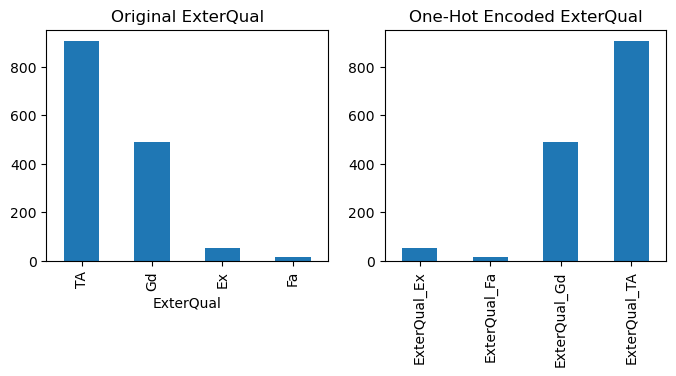

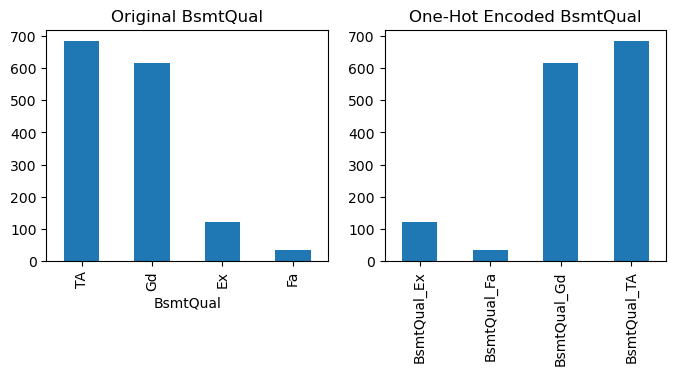

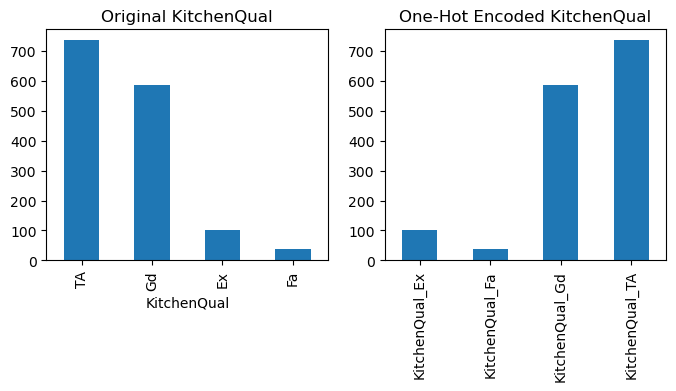

In [10]:
import matplotlib.pyplot as plt

for feature in cat_cols:
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    train_preprocessed[feature].value_counts().plot(kind='bar')
    plt.title(f'Original {feature}')

    plt.subplot(1, 2, 2)
    train_ohe.filter(like=feature).sum().plot(kind='bar')
    plt.title(f'One-Hot Encoded {feature}')
    plt.show()

<font color='green'> **Question 5 - Using ordinary least squares (OLS), try to predict house prices on this dataset. Choose the features
(or combinations of features) you would like to use or ignore, provided you justify your choice.
Evaluate your predictions on the training set using the MSE and the R2 score. For this question,
you need to implement OLS from scratch without using any external libraries or packages.**

In [11]:
print("Final features in training set: ", len(train_preprocessed.drop(['SalePrice'], axis=1).columns))
print(train_preprocessed.drop(['SalePrice'], axis=1).columns);

X = train_ohe.drop(['SalePrice'], axis=1).values
y = train_ohe['SalePrice'].values

theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

y_pred = X.dot(theta)

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def r2_score(y_true, y_pred):
    total_variance = np.sum((y_true - np.mean(y_true)) ** 2)
    unexplained_variance = np.sum((y_true - y_pred) ** 2)
    return 1 - (unexplained_variance / total_variance)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"MSE: {mse}")
print(f"R^2: {r2}")

Final features in training set:  13
Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual',
       'TotRmsAbvGrd', 'GarageCars', 'GarageArea'],
      dtype='object')
MSE: 379917027954.45905
R^2: -59.239379014068774


<font color='green'> **Question 6. Train your model using all of the training data (all data points, but not necessarily all the features), and test it using the testing data. Submit your results to Kaggle.**

In [12]:
test = pd.read_csv('housingprices_test.csv')

test_preprocessed = test.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType'], axis=1)
test_preprocessed = test_preprocessed.drop(dropped_num_cols, axis=1)
test_preprocessed = test_preprocessed.drop(dropped_cat_cols, axis=1)

num_cols2 = test_preprocessed.select_dtypes(include=['int', 'float']).columns
cat_cols2 = test_preprocessed.select_dtypes(include=['object']).columns

for col in num_cols2:
    median_value = test_preprocessed[col].median()  
    test_preprocessed[col].fillna(median_value)  
    
for col in cat_cols2:
    mode_value = test_preprocessed[col].mode()[0]  
    test_preprocessed[col] = test_preprocessed[col].fillna(mode_value)
    
test_preprocessed = min_max_normalize(test_preprocessed, num_cols.drop('SalePrice'))

test_ohe = pd.get_dummies(test_preprocessed, columns=cat_cols)
test_ohe.loc[:, 'ExterQual_Ex':] = test_ohe.loc[:, 'ExterQual_Ex':].astype(int)
test_ohe.head()

/var/folders/45/0sm9f9614w77624c01lr1fx40000gn/T/ipykernel_66016/3252394232.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  test_ohe.loc[:, 'ExterQual_Ex':] = test_ohe.loc[:, 'ExterQual_Ex':].astype(int)
/var/folders/45/0sm9f9614w77624c01lr1fx40000gn/T/ipykernel_66016/3252394232.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  test_ohe.loc[:, 'ExterQual_Ex':] = test_ohe.loc[:, 'ExterQual_Ex':].astype(int)
/var/folders/45/0sm9f9614w77624c01lr1fx40000gn/T/ipykernel_66016/3252394232.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has 

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,...,ExterQual_Gd,ExterQual_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
0,0.444444,0.625954,0.183333,0.173111,0.104309,0.104309,0.25,0.166667,0.2,0.490591,...,0,1,0,0,0,1,0,0,0,1
1,0.555556,0.603053,0.133333,0.260844,0.196672,0.196672,0.25,0.250000,0.2,0.209677,...,0,1,0,0,0,1,0,0,1,0
2,0.444444,0.900763,0.800000,0.182139,0.111135,0.260666,0.50,0.250000,0.4,0.323925,...,0,1,0,0,1,0,0,0,0,1
3,0.555556,0.908397,0.800000,0.181747,0.110708,0.255333,0.50,0.333333,0.4,0.315860,...,0,1,0,0,0,1,0,0,1,0
4,0.777778,0.862595,0.700000,0.251227,0.186220,0.186220,0.50,0.166667,0.4,0.340054,...,1,0,0,0,1,0,0,0,1,0


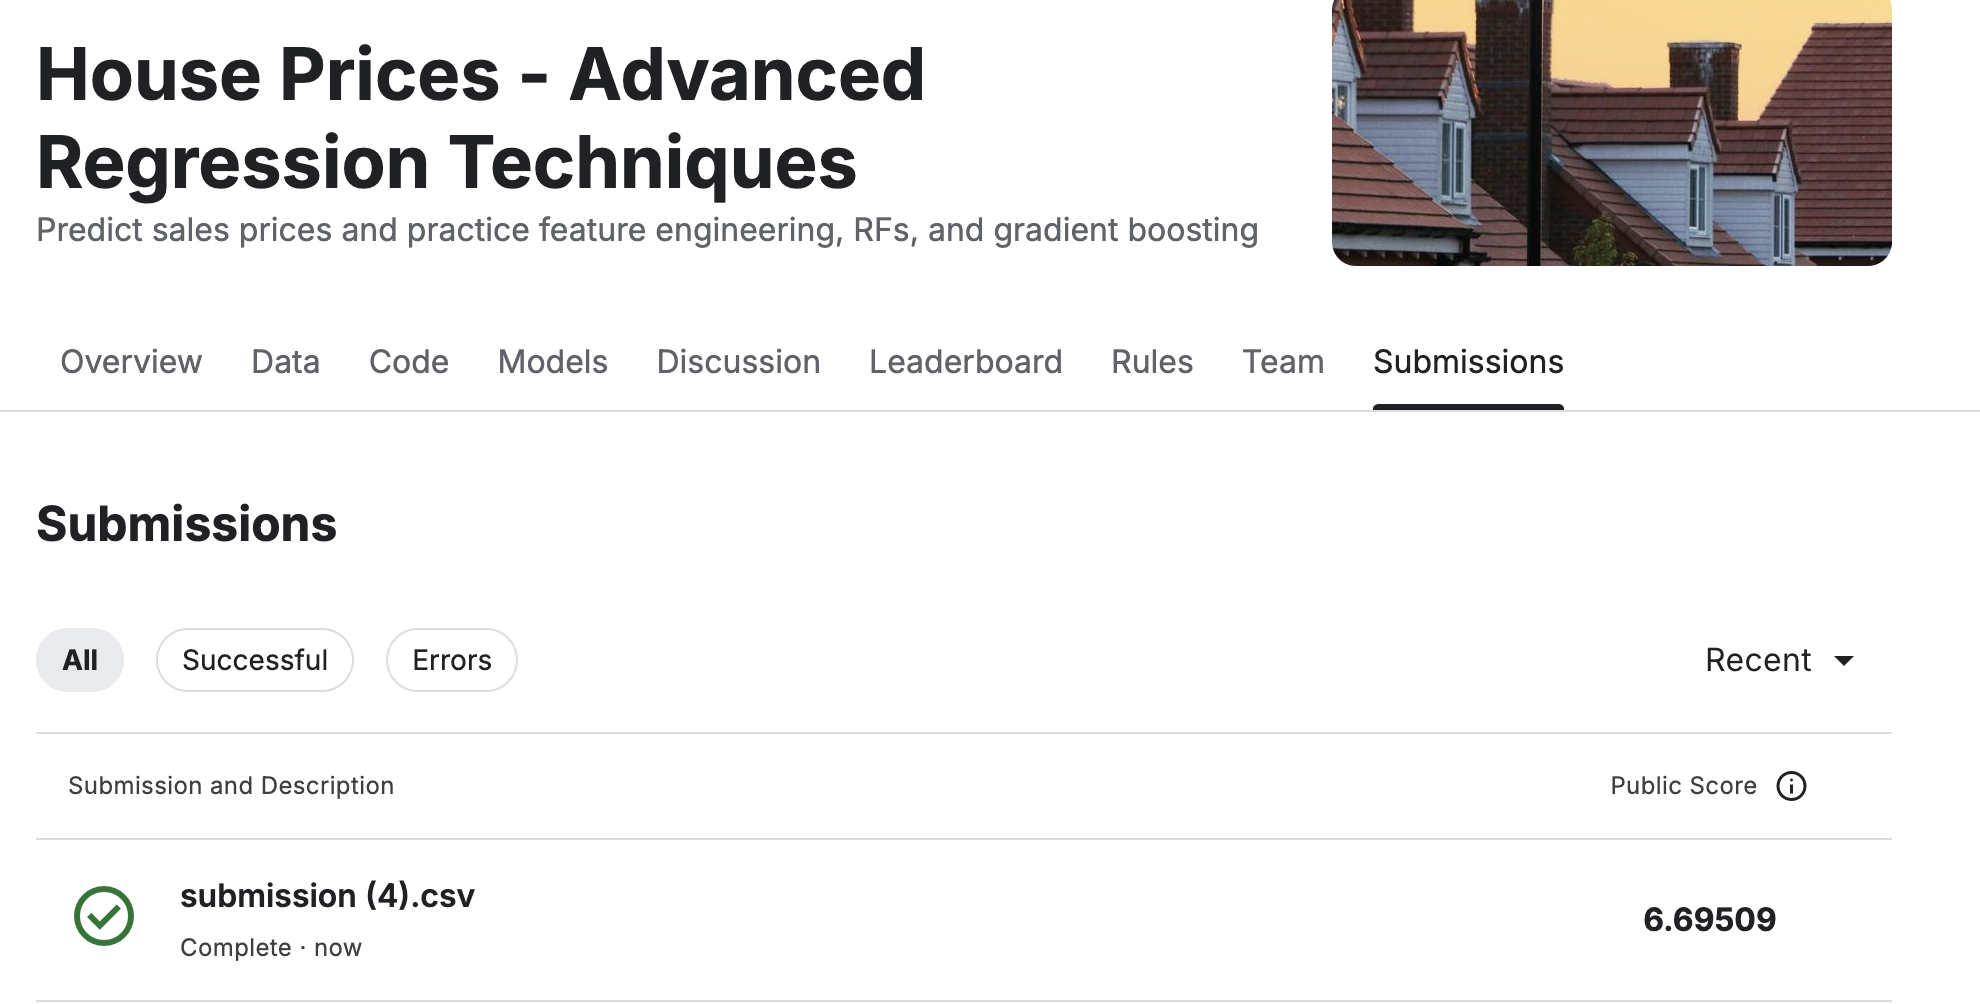

In [13]:
X_test = test_ohe.values

y_test_pred = X_test.dot(theta)

submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': y_test_pred})
submission = submission.fillna(0)
submission.to_csv('submission.csv', index=False)

from IPython.display import Image
Image(filename='Screenshot 2024-09-18 at 8.25.00 PM.png') 

### Part II - Titanic Disaster
https://www.kaggle.com/competitions/titanic

<font color='green'> **Question 1: Join the Titanic - Machine Learning from Disaster competition on Kaggle. Download and preprocess the data.**

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

test = pd.read_csv('titanic_test.csv')
train = pd.read_csv('titanic_train.csv')

<font color='green'> **Question 2: Implement logistic regression (it’s ok to use sklearn or similar software packages), try to predict whether a passenger survived the disaster with your model. Choose the features (or combinations of features) you would like to use or ignore, provided you justify your choice.**

**Step 1) Keeping columns with less than 50% blank values**

I chose to remove columns with more than 50% missing values, namely the 'Cabin' feature. Although I could impute the mean or median of the observed data for the missing values, this approach is unreliable because more than 50% of the observations are blank. Imputing such a large portion of the data could introduce biases.

I also eliminated PassengerId, Name, and Ticket columns. The first two are arbitary features and should not correlate with the target variable. The Ticket column had a gnarly data format, and I did not know how to interpret it. 

In [15]:
nan_values = pd.DataFrame(train.isnull().sum(axis = 0)).sort_values(by=0, ascending=False)
nan_values['NanValuePercent'] = nan_values[0]/len(train)
print(nan_values[nan_values.NanValuePercent >= 0.5])

X_train = train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

         0  NanValuePercent
Cabin  687         0.771044


**Step 2) Extracting useful information from categorical features**

I extracted Title (Mr, Miss, etc.) from the Name column, so that I could use it as a feature. I know our dataset already has sex, but I think Title gives more granularity. 

I also one-hot-encoded 'Sex', 'Title', and 'Embarked' categorical features, as it is a more compatible format with logistic regression model. 

In [16]:
pattern = r'\b(Mr|Ms|Miss|Mrs|Dr|Master|Rev)\b'
X_train['Title'] = train['Name'].str.extract(pattern)

X_train = pd.get_dummies(X_train, columns=['Title', 'Sex', 'Embarked'], drop_first=True)

/var/folders/45/0sm9f9614w77624c01lr1fx40000gn/T/ipykernel_66016/4117189932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Title'] = train['Name'].str.extract(pattern)


**Step 3) Missing blank values with median and normalizing numerical data**

Filling missing values prevents losing data that might otherwise be excluded from analysis or modeling. 
I chose to normalize features so that all features contribute equally to the model and the regression coefficients are easier to interpret. 

In [17]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_train['Age'] = imputer.fit_transform(X_train[['Age']])
X_train['Fare'] = imputer.fit_transform(X_train[['Fare']])

scaler = StandardScaler()
X_train['Fare'] = scaler.fit_transform(X_train[['Fare']])
X_train['Age'] = scaler.fit_transform(X_train[['Age']])
X_train['Pclass'] = scaler.fit_transform(X_train[['Pclass']])

**Step 3) Implementing Logistic Regression**


In [18]:
#Testing accuracy on train test
y_train = train['Survived']
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

<font color='green'> **Question 3 -Train your classifier using all of the training data, and test it using the testing data. Submit your results to Kaggle.**

In [19]:
#Feature engineering test dataset much like training dataset
test = pd.read_csv('titanic_test.csv')
X_test = test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

X_test['Title'] = test['Name'].str.extract(pattern)

X_test = pd.get_dummies(X_test, columns=['Title', 'Sex', 'Embarked'], drop_first=True)

X_test['Age'] = imputer.fit_transform(X_test[['Age']])
X_test['Fare'] = imputer.fit_transform(X_test[['Fare']])

scaler = StandardScaler()
X_test['Fare'] = scaler.fit_transform(X_test[['Fare']])
X_test['Age'] = scaler.fit_transform(X_test[['Age']])
X_test['Pclass'] = scaler.fit_transform(X_test[['Pclass']])


/var/folders/45/0sm9f9614w77624c01lr1fx40000gn/T/ipykernel_66016/2302667798.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Title'] = test['Name'].str.extract(pattern)


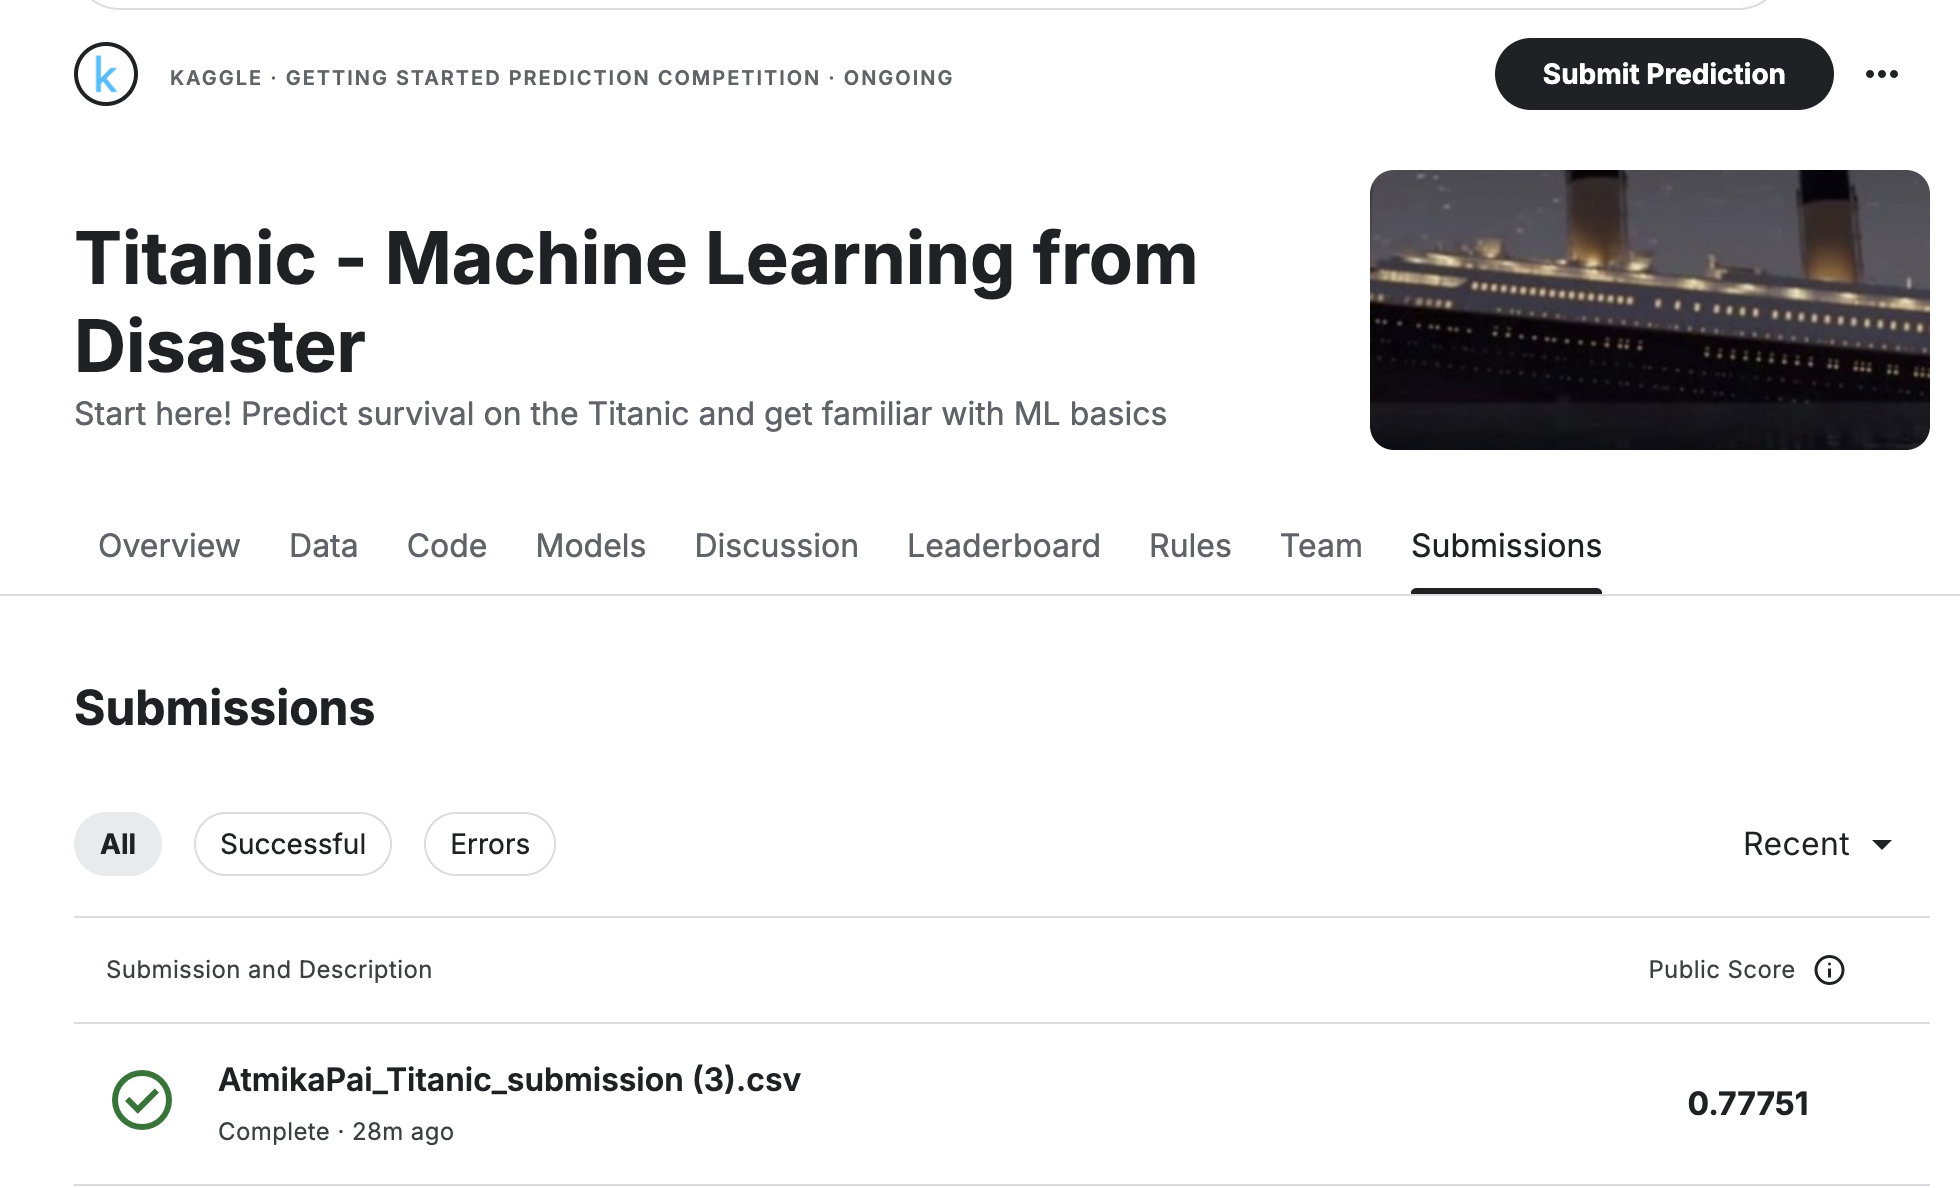

In [20]:
test_predictions = model.predict(X_test)

submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_predictions
})

submission.to_csv('AtmikaPai_Titanic_submission.csv', index=False)

from IPython.display import Image
Image(filename='Screenshot 2024-09-18 at 8.23.15 PM.png') 